In [4]:
from sklearn.neural_network import MLPClassifier
import project_metrics.project_metrics as metrics
import numpy as np
import pandas as pd
import pickle
import joblib
from os.path import exists

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
df_train = pd.read_csv("Assets/train.csv")
df_val= pd.read_csv("Assets/val.csv")
df_test = pd.read_csv("Assets/test.csv")

In [6]:
df_train.drop("INDEX", inplace=True, axis =1)
df_val.drop("INDEX", inplace=True, axis =1)
df_test.drop("INDEX", inplace=True, axis =1)

df_train.drop("Unnamed: 0", inplace=True, axis =1)
df_val.drop("Unnamed: 0", inplace=True, axis =1)
df_test.drop("Unnamed: 0", inplace=True, axis =1)

df_train.drop("IND_BOM_1_2", inplace=True, axis =1)
df_val.drop("IND_BOM_1_2", inplace=True, axis =1)
df_test.drop("IND_BOM_1_2", inplace=True, axis =1)

In [7]:
y_train = df_train["IND_BOM_1_1"].values
y_val = df_val["IND_BOM_1_1"].values
y_test = df_test["IND_BOM_1_1"].values

In [8]:
df_train.drop("IND_BOM_1_1", inplace=True, axis =1)
df_val.drop("IND_BOM_1_1", inplace=True, axis =1)
df_test.drop("IND_BOM_1_1", inplace=True, axis =1)

In [9]:
x_train = df_train.values
x_val = df_val.values
x_test = df_test.values

In [10]:
x_train.shape

(255098, 243)

# Final Project

## MLP

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import keras

MODELS_PATH = "Models/MLP"
HISTORY_PATH = f"{MODELS_PATH}/history"
MODEL_PATH = f"{MODELS_PATH}/model"

### Experimento1

In [12]:

input_dim = x_train.shape[1]

classifier = Sequential()

classifier.add(Dense(16, activation='relu', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "1.npy"
model_file = MODEL_PATH + "1"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=10,verbose=1)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

2022-10-18 22:23:47.537350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 22:23:47.538269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 22:23:47.538490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-18 22:23:47.538539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-18 22:23:47.538582: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model was already trained


2022-10-18 22:23:47.899294: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 2s 612us/step
Matriz de confusão no conjunto de teste:


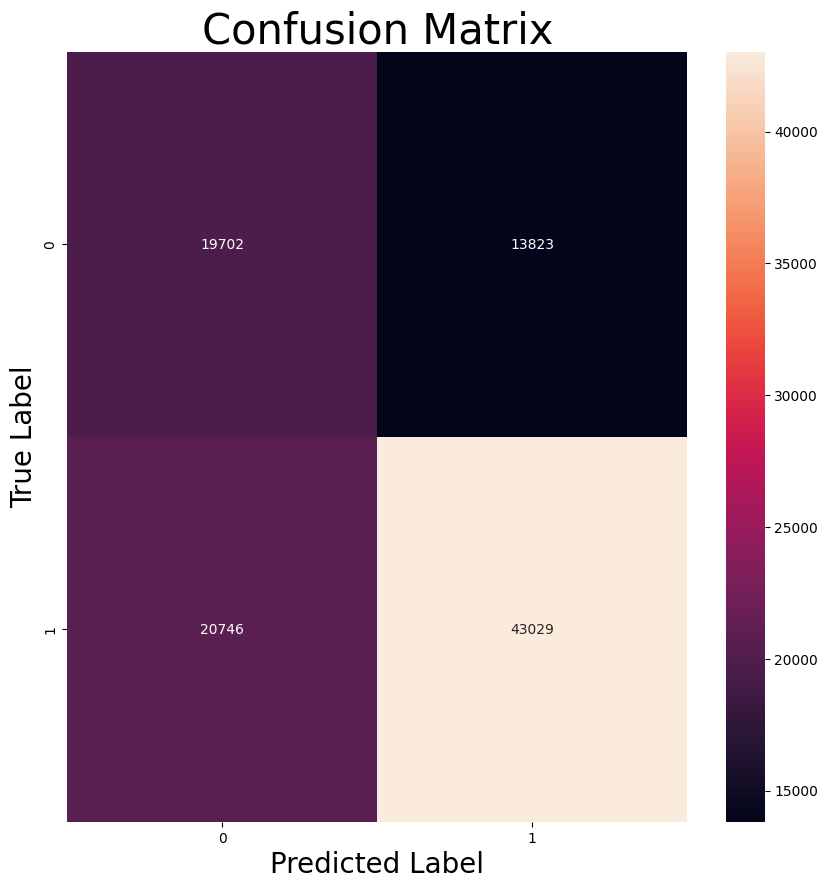


Train Loss:       0.2187
Validation Loss:  0.2214

Performance no conjunto de teste:


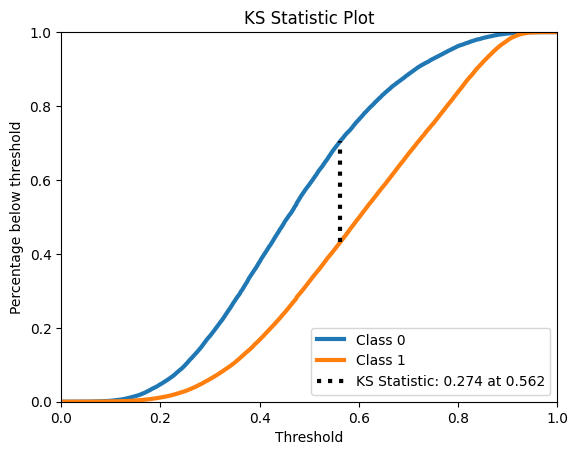


Accuracy:         0.6447
Recall:           0.6747
Precision:        0.7569
F1:               0.7134
AUROC:            0.6887
AUPR:             0.8014


In [13]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento2

In [14]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(256, activation='relu', input_dim=input_dim))
classifier.add(Dense(128, activation='relu', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "2.npy"
model_file = MODEL_PATH + "2"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=10_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


 139/3041 [>.............................] - ETA: 2s

2022-10-18 22:23:51.832060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 2s 741us/step
Matriz de confusão no conjunto de teste:


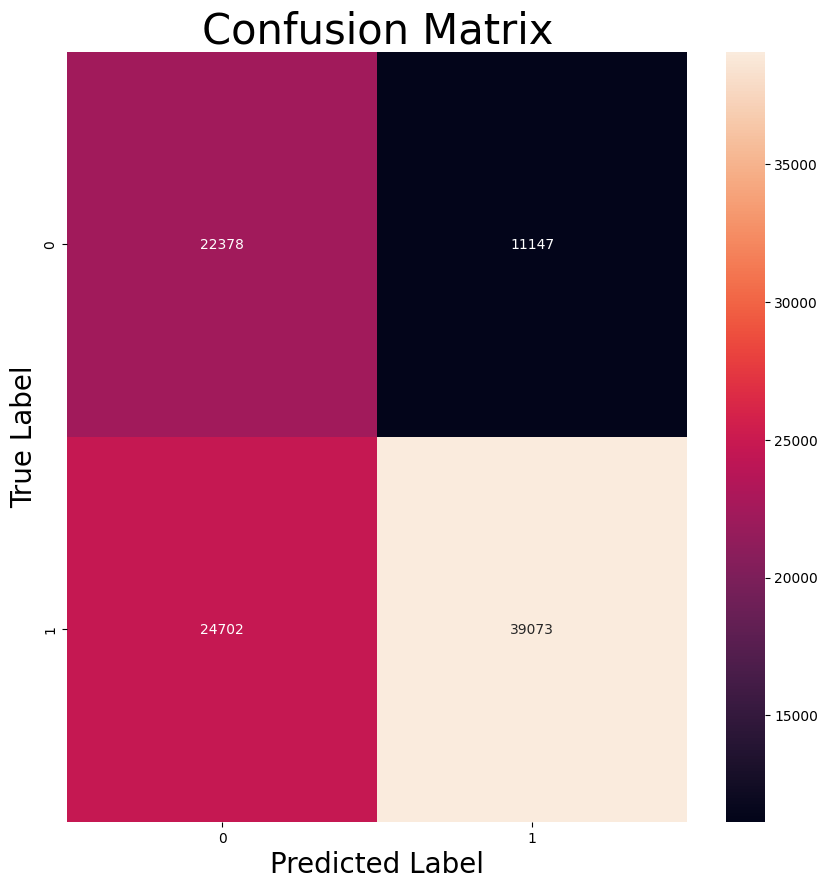


Train Loss:       0.2206
Validation Loss:  0.2213

Performance no conjunto de teste:


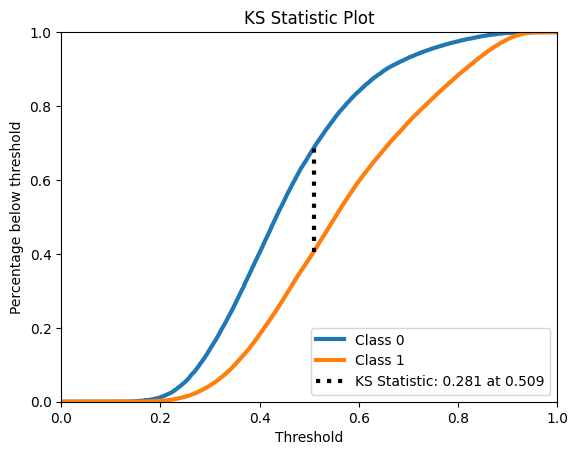


Accuracy:         0.6316
Recall:           0.6127
Precision:        0.7780
F1:               0.6855
AUROC:            0.6921
AUPR:             0.8042


In [15]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento3

In [16]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(512, activation='sigmoid', input_dim=input_dim))
classifier.add(Dense(256, activation='sigmoid', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))

optimizer=keras.optimizers.SGD( learning_rate=0.01)
classifier.compile(optimizer=optimizer, loss='mean_squared_error')

history_file = HISTORY_PATH + "3.npy"
model_file = MODEL_PATH + "3"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=1_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


  99/3041 [..............................] - ETA: 3s

2022-10-18 22:23:55.685318: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 3s 963us/step
Matriz de confusão no conjunto de teste:


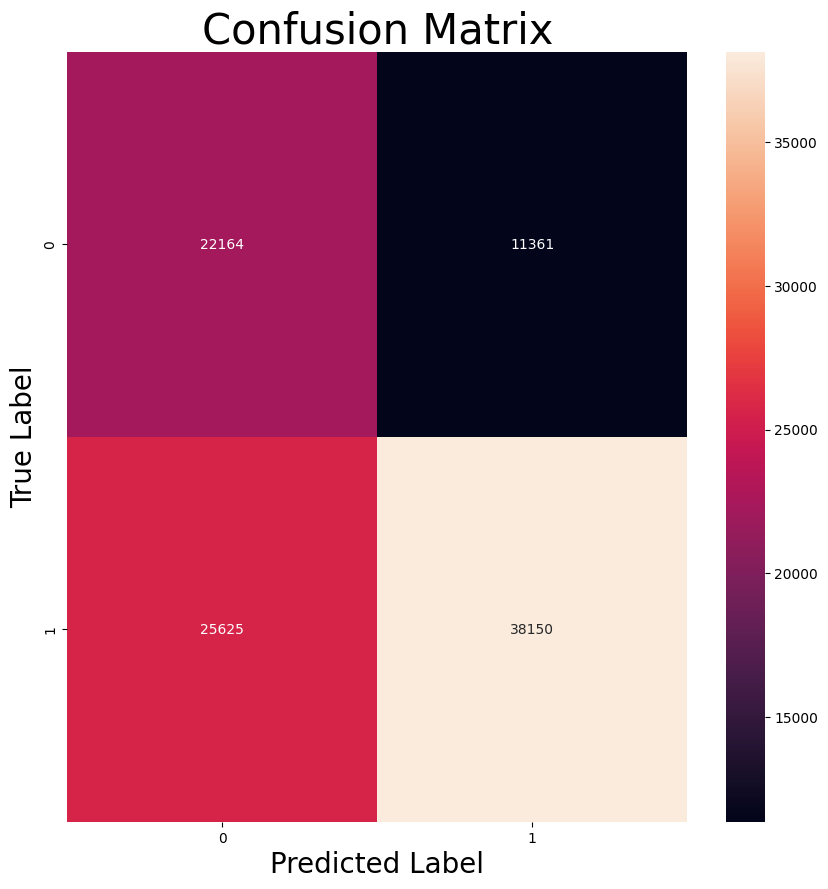


Train Loss:       0.2258
Validation Loss:  0.2255

Performance no conjunto de teste:


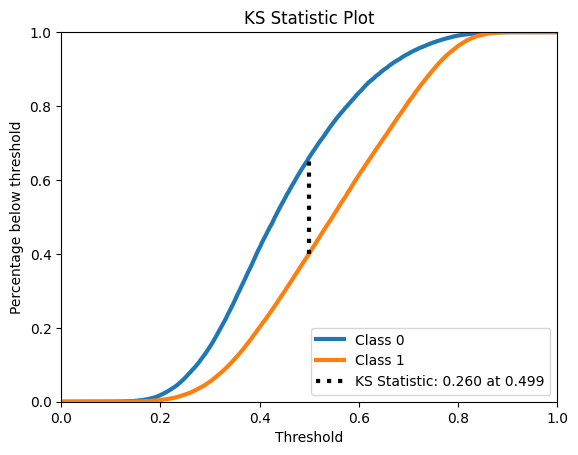


Accuracy:         0.6199
Recall:           0.5982
Precision:        0.7705
F1:               0.6735
AUROC:            0.6774
AUPR:             0.7885


In [17]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento4

In [18]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(512, activation='tanh', input_dim=input_dim))
classifier.add(Dense(256, activation='tanh', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))

optimizer=keras.optimizers.SGD( learning_rate=0.01)
classifier.compile(optimizer=optimizer, loss='mean_squared_error')

history_file = HISTORY_PATH + "4.npy"
model_file = MODEL_PATH + "4"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=1_000, callbacks=[EarlyStopping(patience=20,verbose=1,restore_best_weights=True)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


 111/3041 [>.............................] - ETA: 2s

2022-10-18 22:24:00.252776: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 3s 905us/step
Matriz de confusão no conjunto de teste:


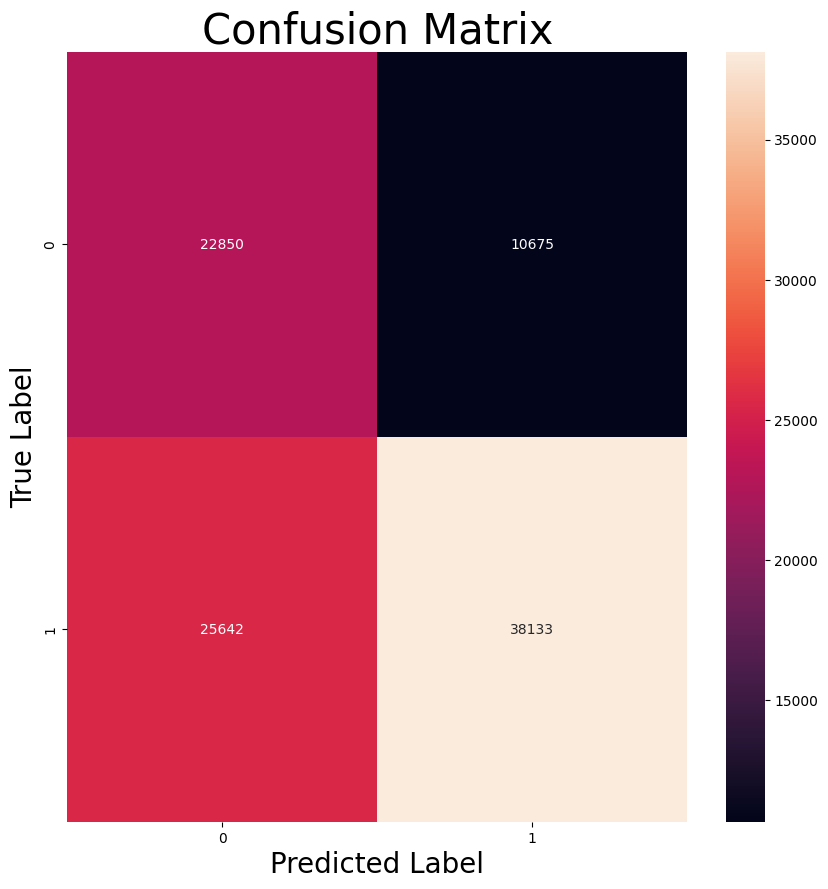


Train Loss:       0.2174
Validation Loss:  0.2212

Performance no conjunto de teste:


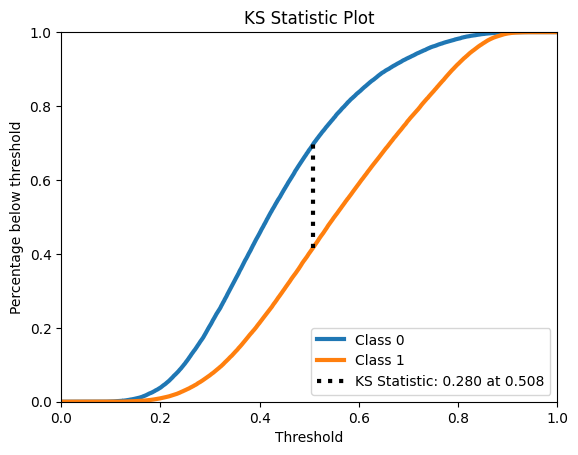


Accuracy:         0.6268
Recall:           0.5979
Precision:        0.7813
F1:               0.6774
AUROC:            0.6925
AUPR:             0.8028


In [19]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento5

In [20]:
# Número de features do nosso data set.
input_dim = x_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(1024, activation='tanh', input_dim=input_dim))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='mean_squared_error')

history_file = HISTORY_PATH + "5.npy"
model_file = MODEL_PATH + "5"

if not exists(history_file) or  not exists(model_file):
    history = classifier.fit(x_train, y_train, batch_size=32, epochs=1_000, callbacks=[EarlyStopping(patience=20,verbose=1)], validation_data=(x_val, y_val))
    np.save(history_file,history.history)
    classifier.save(model_file)
else:
    print("Model was already trained")
    
history=np.load(history_file, allow_pickle='TRUE').item()
classifier = keras.models.load_model(model_file)

Model was already trained


 106/3041 [>.............................] - ETA: 2s

2022-10-18 22:24:04.783785: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 94575600 exceeds 10% of free system memory.


3041/3041 [==============================] - 3s 975us/step
Matriz de confusão no conjunto de teste:


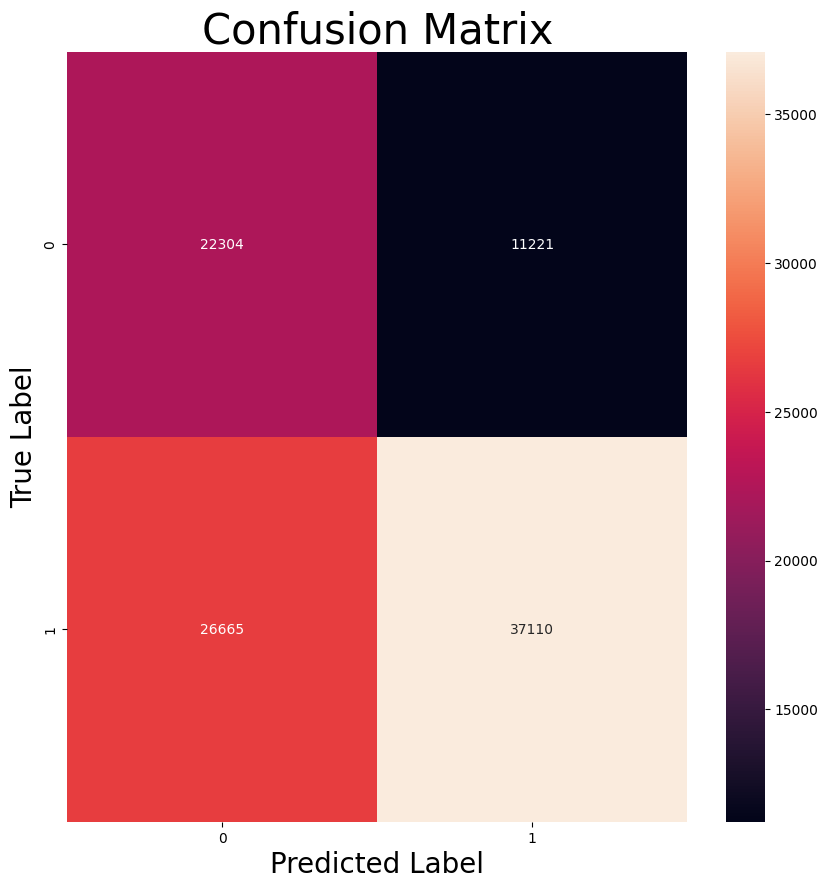


Train Loss:       0.2259
Validation Loss:  0.2234

Performance no conjunto de teste:


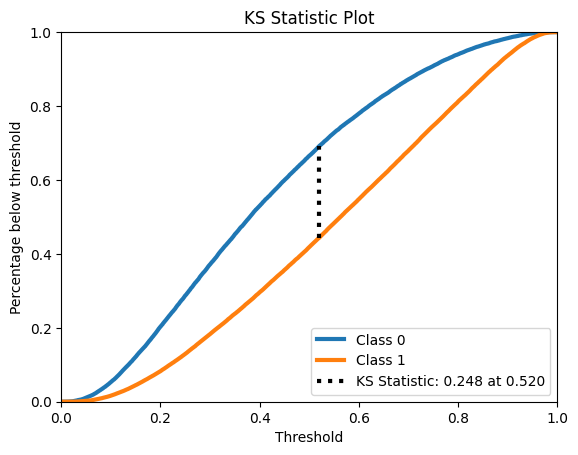


Accuracy:         0.6106
Recall:           0.5819
Precision:        0.7678
F1:               0.6621
AUROC:            0.6690
AUPR:             0.7847


In [21]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(x_test)
y_pred_class = (y_pred_scores > 0.5).astype("int32")
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
metrics.plot_confusion_matrix(y_test, y_pred_class)

## Resumo dos resultados
losses = metrics.extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento 6

In [22]:
# history_file = HISTORY_PATH + "6.npy"
# model_file = MODEL_PATH + "6"

# classifier = KerasClassifier(build_fn=create_sklearn_compatible_model, batch_size = 64, epochs = 100, verbose = 1, callbacks=[EarlyStopping(patience=20,verbose=1)], validation_data=(x_val, y_val))

# if not exists(history_file) or  not exists(model_file):
#     history = classifier.fit(x_train, y_train)
#     np.save(history_file,history.history)
#     classifier.save(model_file)
# else:
#     print("Model was already trained")
    
# history=np.load(history_file, allow_pickle='TRUE').item()
# classifier = keras.models.load_model(model_file)

## MLP Ensemble

In [23]:
MLP_ENS_PATH = "Models/MLP_ENS"
MLP_MODEL_ENS_PATH = f"{MLP_ENS_PATH}/model"

### Experimento1

In [24]:
mlp = MLPClassifier(verbose=True)
mlp1 = MLPClassifier(verbose=True)
mlp2 = MLPClassifier(verbose=True)
mlp3 = MLPClassifier(verbose=True)

model_file = MLP_MODEL_ENS_PATH+"1"
if not exists(model_file):
    mlp_ns = mlp.fit(x_train,y_train)
    mlp_ens = VotingClassifier([('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp1)], voting='soft')
    mlp_ens.fit(x_train,y_train)
    with open(MLP_MODEL_ENS_PATH+"1", 'wb') as file:
        pickle.dump(mlp_ens,file)
    with open(MLP_MODEL_ENS_PATH+"ns"+"1", 'wb') as file:
        pickle.dump(mlp_ns,file)
else:
    print("Model was already trained")
    with open(MLP_MODEL_ENS_PATH+"1", 'rb') as file:
        mlp_ens = pickle.load(file)
    with open(MLP_MODEL_ENS_PATH+"ns"+"1", 'rb') as file:
        mlp_ns= pickle.load(file)

Model was already trained


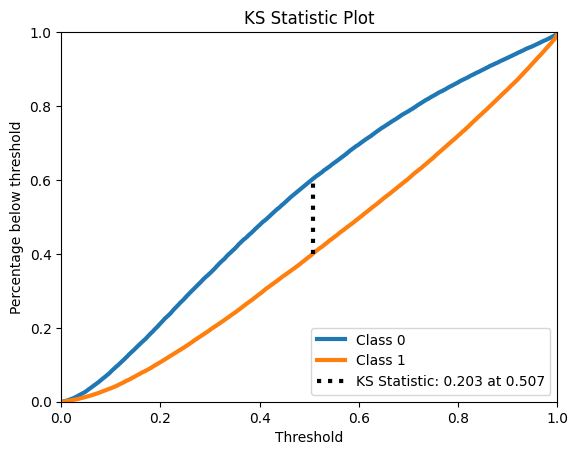

Performance no conjunto de validação:

Accuracy:         0.6031
Recall:           0.6074
Precision:        0.7405
F1:               0.6674
AUROC:            0.6362
AUPR:             0.7523


In [27]:
mlp_pred_class = mlp_ns.predict(x_test)
mlp_pred_scores = mlp_ns.predict_proba(x_test)
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

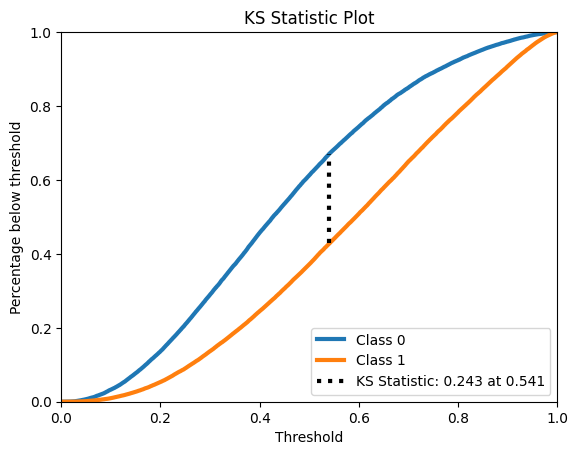

Performance no conjunto de validação:

Accuracy:         0.6231
Recall:           0.6285
Precision:        0.7554
F1:               0.6861
AUROC:            0.6652
AUPR:             0.7821


In [25]:
mlp_pred_class = mlp_ens.predict(x_test)
mlp_pred_scores = mlp_ens.predict_proba(x_test)
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento2

In [29]:
mlp1 = MLPClassifier(activation="relu",verbose=True)
mlp2 = MLPClassifier(activation="logistic", verbose=True)
mlp3 = MLPClassifier(activation="tanh", verbose=True)

model_file = MLP_MODEL_ENS_PATH+"2"
if not exists(model_file):
    mlp_ens = VotingClassifier([('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp1)], voting='soft')
    mlp_ens.fit(x_train,y_train)
    with open(model_file, 'wb') as file:
        pickle.dump(mlp_ens,file)
else:
    print("Model was already trained")
    with open(model_file, 'rb') as file:
        mlp_ens = pickle.load(file)

Iteration 1, loss = 0.64854404
Iteration 2, loss = 0.63668057
Iteration 3, loss = 0.63203670
Iteration 4, loss = 0.62869163
Iteration 5, loss = 0.62574687
Iteration 6, loss = 0.62280828
Iteration 7, loss = 0.61974125
Iteration 8, loss = 0.61698176
Iteration 9, loss = 0.61422970
Iteration 10, loss = 0.61166986
Iteration 11, loss = 0.60873855
Iteration 12, loss = 0.60620630
Iteration 13, loss = 0.60387255
Iteration 14, loss = 0.60189606
Iteration 15, loss = 0.59953513
Iteration 16, loss = 0.59685819
Iteration 17, loss = 0.59510271
Iteration 18, loss = 0.59304009
Iteration 19, loss = 0.59144132
Iteration 20, loss = 0.58947627
Iteration 21, loss = 0.58790658
Iteration 22, loss = 0.58584669
Iteration 23, loss = 0.58430295
Iteration 24, loss = 0.58263159


In [ ]:
mlp_ens.fit(x_train, y_train)
mlp_pred_class = mlp_ens.predict(x_test)
mlp_pred_scores = mlp_ens.predict_proba(x_test)
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento3

In [ ]:
mlp1 = MLPClassifier(solver="lbfgs",verbose=True)
mlp2 = MLPClassifier(solver="sgd", verbose=True)
mlp3 = MLPClassifier(solver="adam", verbose=True)

model_file = MLP_MODEL_ENS_PATH+"3"
if not exists(model_file):
    mlp_ens = VotingClassifier([('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp1)], voting='soft')
    mlp_ens.fit(x_train,y_train)
    with open(model_file, 'wb') as file:
        pickle.dump(mlp_ens,file)
else:
    print("Model was already trained")
    with open(model_file, 'rb') as file:
        mlp_ens = pickle.load(file)

In [ ]:
mlp_ens.fit(x_train, y_train)
mlp_pred_class = mlp_ens.predict(x_test)
mlp_pred_scores = mlp_ens.predict_proba(x_test)
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento4

In [ ]:
mlp1 = MLPClassifier(hidden_layer_size=(16,), activation="relu", solver="adam", verbose=True)
mlp2 = MLPClassifier(hidden_layer_size=(64,32), activation="tanh", solver="sgd", verbose=True)
mlp3 = MLPClassifier(activation="logistic", solver="lbfgs" verbose=True)

model_file = MLP_MODEL_ENS_PATH+"4"
if not exists(model_file):
    mlp_ens = VotingClassifier([('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp1)], voting='soft')
    mlp_ens.fit(x_train,y_train)
    with open(model_file, 'wb') as file:
        pickle.dump(mlp_ens,file)
else:
    print("Model was already trained")
    with open(model_file, 'rb') as file:
        mlp_ens = pickle.load(file)

In [ ]:
mlp_ens.fit(x_train, y_train)
mlp_pred_class = mlp_ens.predict(x_test)
mlp_pred_scores = mlp_ens.predict_proba(x_test)
accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
# def sklearn_compatible_model(neurons:tuple,activation:tuple, optimizer="adam"):
#     def mlp_generator():
#         classifier = Sequential()
#         classifier.add(Dense(neurons[0], activation=activation[0], input_dim=input_dim))
#         classifier.add(Dense(neurons[-1], activation=activation[-1], input_dim=input_dim))
#         classifier.add(Dense(1, activation='sigmoid'))
#         classifier.compile(optimizer='adam', loss='mean_squared_error')
#         return classifier
#     return mlp_generator 

In [ ]:
# def keras_classifier_generator(neurons,activation,optimizer="adam",epochs=100,patience=10) -> KerasClassifier:
#     classifier:KerasClassifier = KerasClassifier(build_fn=sklearn_compatible_model(
#         neurons=neurons,
#         activation=activation,
#         optimizer=optimizer),
#         batch_size=32,
#         epochs=epochs,
#         verbose=1,
#         callbacks=[EarlyStopping(patience=patience,verbose=1)], validation_data=(x_val, y_val),
#         )
#     classifier._estimator_type = "classifier"
#     return classifier

### Experimento1

In [ ]:
# mlp1=keras_classifier_generator(neurons=(64,32), activation=("relu","relu"), epochs=10)
# mlp2=keras_classifier_generator(neurons=(64,32), activation=("sigmoid","sigmoid"), epochs=10)
# mlp3=keras_classifier_generator(neurons=(64,32), activation=("tanh","tanh"),epochs=10)

# model_file = MLP_MODEL_ENS_PATH+"1"
# if not exists(model_file):
#     mlp_ens = VotingClassifier([('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp1)], voting='soft')
#     mlp_ens.fit(x_train,y_train)
#     with open(MLP_MODEL_ENS_PATH+"1", 'wb') as file:
#         pickle.dump(mlp_ens,file)
# else:
#     print("Model was already trained")
#     with open(MLP_MODEL_ENS_PATH+"1", 'rb') as file:
#         mlp_ens = pickle.load(file)

# # Fazer predições no conjunto de teste
# y_pred_scores = classifier.predict(x_test)
# y_pred_class = (y_pred_scores > 0.5).astype("int32")
# y_pred_scores_0 = 1 - y_pred_scores
# y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

# ## Matriz de confusão
# print('Matriz de confusão no conjunto de teste:')
# metrics.plot_confusion_matrix(y_test, y_pred_class)

# ## Resumo dos resultados
# losses = metrics.extract_final_losses(history)
# print()
# print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
# print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
# print('\nPerformance no conjunto de teste:')
# accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
# metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)   

In [ ]:
# mlp_ens.save(MLP_MODEL_ENS_PATH+"1")

### Experimento2

In [ ]:
# with open(MLP_MODEL_ENS_PATH+"1", 'wb') as file:
#     joblib.dump(mlp_ens,file)

## Gradient Boosting

In [ ]:
GB_PATH = "Models/GB"
GB_MODEL_PATH = f"{GB_PATH}/model"

### Experimento1

In [ ]:
# gb_clf = GradientBoostingClassifier()  

# if not exists(model_file):
#     gb_clf.fit(x_train, y_train)
#     with open(MLP_ENS_PATH+"1", 'wb') as file:
#         pickle.dump(gb_clf,file)
# else:
#     print("Model was already trained")
#     with open(MLP_ENS_PATH+"1", 'rb') as file:
#         gb_clf = pickle.load(file)

# gb_pred_class = gb_clf.predict(x_test)
# gb_pred_scores = gb_clf.predict_proba(x_test)
# accuracy, recall, precision, f1, auroc, aupr = metrics.compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
# metrics.print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
# metrics.plot_confusion_matrix(y_test, gb_pred_class)
